# Policy Gradient para Reinforcement Learning

In [ ]:
!pip3 uninstall numpy -y
!pip3 install numpy==1.23.5
!pip3 install pygame

In [8]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt

In [9]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('threshold: ', env.spec.reward_threshold)

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)
threshold:  475.0


Este ambiente de gym es parte de https://www.gymlibrary.dev/environments/classic_control. El ambiente específico con el que trabajaremos en este notebook es https://www.gymlibrary.dev/environments/classic_control/cart_pole/

In [10]:
obs_size = env.observation_space.shape[0] 
n_actions = env.action_space.n  
HIDDEN_SIZE = 256

model = torch.nn.Sequential(
             torch.nn.Linear(obs_size, HIDDEN_SIZE),
             torch.nn.ReLU(),
             torch.nn.Linear(HIDDEN_SIZE, n_actions),
             torch.nn.Softmax(dim=0)
     )

print (model)

Sequential(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=2, bias=True)
  (3): Softmax(dim=0)
)


In [11]:
learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Horizon = 500
MAX_TRAJECTORIES = 500
gamma = 0.99
score = [] 

for trajectory in range(MAX_TRAJECTORIES):
    curr_state = env.reset()
    done = False
    transitions = [] 
    
    for t in range(Horizon):
        if t == 0:
            act_prob = model(torch.from_numpy(curr_state[0]).float())
        else:
            act_prob = model(torch.from_numpy(curr_state).float())

        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy())

        if t == 0:
            prev_state = curr_state[0]
        else:
            prev_state = curr_state

        curr_state, _, done, info, _ = env.step(action)
        transitions.append((prev_state, action, t+1)) 

        if done: 
            break
        
    score.append(len(transitions))
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,)) 

    batch_Gvals =[]
    for i in range(len(transitions)):
        new_Gval=0
        power=0
        for j in range(i,len(transitions)):
             new_Gval=new_Gval+((gamma**power)*reward_batch[j]).numpy()
             power+=1
        batch_Gvals.append(new_Gval)
    expected_returns_batch=torch.FloatTensor(batch_Gvals)
    
    
    expected_returns_batch /= expected_returns_batch.max()

    state_batch = torch.Tensor([s for (s,a,r) in transitions]) 
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) 

    pred_batch = model(state_batch) 
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze() 
    
    loss = - torch.sum(torch.log(prob_batch) * expected_returns_batch) 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if trajectory % 50 == 0 and trajectory>0:
            print('Trajectory {}\tAverage Score: {:.2f}'.format(trajectory, np.mean(score[-50:-1])))
     

Trajectory 50	Average Score: 37.37
Trajectory 100	Average Score: 57.86
Trajectory 150	Average Score: 117.20
Trajectory 200	Average Score: 203.90
Trajectory 250	Average Score: 161.94
Trajectory 300	Average Score: 355.51
Trajectory 350	Average Score: 323.20
Trajectory 400	Average Score: 309.53
Trajectory 450	Average Score: 475.65


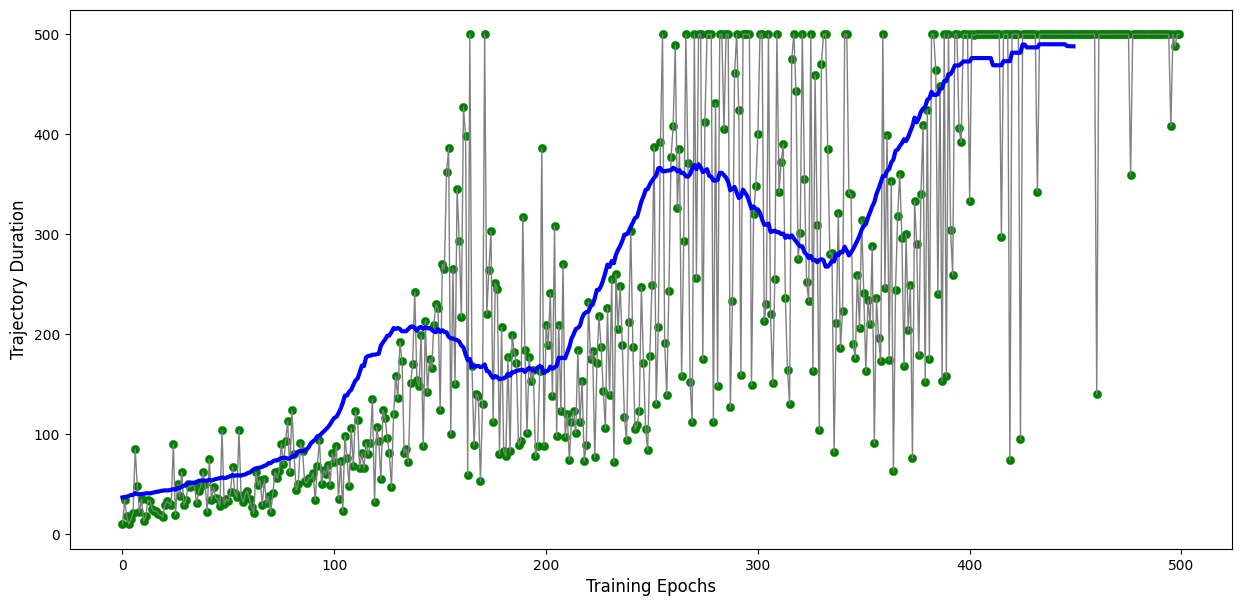

In [12]:
def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y


score = np.array(score)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, color='green' , linewidth=0.3)

In [ ]:
from tqdm import tqdm

n=500

env = gym.make("CartPole-v1", render_mode="human")
env.action_space.seed(82)

state = env.reset(seed=82)
rewards = []

for t in tqdm(range(n)):
    pred = model(torch.from_numpy(state[0]).float())
    action = np.random.choice(np.array([0,1]), p=pred.data.numpy())

    observation,reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    
    if terminated or truncated:
        observation, info = env.reset()
        print("Reward:", sum([r for r in rewards]))

env.close()

  3%|▎         | 17/500 [00:00<00:10, 45.96it/s]

Reward: 12.0


  7%|▋         | 37/500 [00:00<00:10, 45.04it/s]

Reward: 30.0


 11%|█▏        | 57/500 [00:01<00:09, 45.18it/s]

Reward: 48.0


 17%|█▋        | 87/500 [00:01<00:09, 45.39it/s]

Reward: 78.0


 26%|██▋       | 132/500 [00:02<00:08, 45.75it/s]

Reward: 123.0


 28%|██▊       | 142/500 [00:03<00:07, 44.98it/s]

Reward: 135.0


 31%|███▏      | 157/500 [00:03<00:07, 45.07it/s]

Reward: 148.0


 37%|███▋      | 187/500 [00:04<00:06, 45.82it/s]

Reward: 178.0


 43%|████▎     | 217/500 [00:04<00:06, 45.67it/s]

Reward: 208.0


 45%|████▌     | 227/500 [00:04<00:06, 45.10it/s]

Reward: 219.0


 53%|█████▎    | 267/500 [00:05<00:05, 45.67it/s]

Reward: 260.0


 55%|█████▌    | 277/500 [00:06<00:04, 44.84it/s]

Reward: 269.0


 57%|█████▋    | 287/500 [00:06<00:04, 44.31it/s]

Reward: 279.0


 65%|██████▌   | 327/500 [00:07<00:03, 45.58it/s]

Reward: 322.0


 70%|███████   | 352/500 [00:07<00:03, 45.57it/s]

Reward: 344.0


 72%|███████▏  | 362/500 [00:07<00:03, 44.87it/s]

Reward: 356.0


 75%|███████▌  | 377/500 [00:08<00:02, 44.87it/s]

Reward: 369.0


 77%|███████▋  | 387/500 [00:08<00:02, 44.35it/s]

Reward: 381.0


 81%|████████▏ | 407/500 [00:08<00:02, 45.20it/s]

Reward: 399.0


 84%|████████▍ | 422/500 [00:09<00:01, 44.97it/s]

Reward: 415.0


 89%|████████▉ | 447/500 [00:09<00:01, 45.32it/s]

Reward: 438.0


 91%|█████████▏| 457/500 [00:10<00:00, 44.65it/s]

Reward: 451.0


 96%|█████████▋| 482/500 [00:10<00:00, 45.42it/s]

Reward: 474.0


 98%|█████████▊| 492/500 [00:10<00:00, 44.79it/s]

Reward: 487.0


100%|██████████| 500/500 [00:10<00:00, 45.49it/s]


Reward: 500.0


: 

### Referencias

- https://lilianweng.github.io/posts/2018-02-19-rl-overview/#key-concepts
- https://lilianweng.github.io/posts/2018-04-08-policy-gradient/
- https://github.com/jorditorresBCN/Deep-Reinforcement-Learning-Explained/blob/master/DRL_19_REINFORCE_Algorithm.ipynb